# ML Classifier Copies - Wine Model Example

An example where we take an existing "black box" classifier model of the publicly available [Wine Quality dataset](https://archive-beta.ics.uci.edu/ml/datasets/wine+quality), that we can query in order to obtain a copy.

Since we don't know the orginal model family, we will build several copies from different model families and compare the copy fidelity and performance.

(NOTE: Since we **did** build this model, we do have in fact all information.)

<a name="Index">
    
----
# Table of contents

    
1. [**Load original model**](#Original)
2. [**Build copies**](#Copies)
3. [**Evaluate copies**](#Evaluation)
----

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
sys.path.append("../")

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from presc.dataset import Dataset
from presc.copies.copying import ClassifierCopy
from presc.copies.sampling import grid_sampling, normal_sampling, spherical_balancer_sampling, labeling
from ML_copies_original_models import WinesModel, OccupancyModel, SegmentationModel

[Index](#Index)  
  
  


<a name="Original">  

-----
-----
# Load original model

In [12]:
wine_model = WinesModel()

[Index](#Index)  
  
  


<a name="Copies">  

-----
# Build copies

In [13]:
log_normal_classifier = Pipeline([('scaler', StandardScaler()), ('log_classifier', 
                                   LogisticRegression())])
tree_normal_classifier = DecisionTreeClassifier()
svm_normal_classifier = Pipeline([('scaler', StandardScaler()), ('SVC_classifier', SVC(kernel="linear"))])

We will assume that we don't know anything about the distribution of the numerical features, but that we can normalize them as a pre-processing step before training the model and thus force them to be centered at 0 and have a standard deviation of 1.

In [14]:
feature_description = wine_model.feature_description

In [15]:
balance_parameters={"max_iter": 50, "nbatch": 1500, "verbose": False}
log_normal_copy = ClassifierCopy(wine_model.model, log_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=2000, random_state=42,
                                 feature_parameters=feature_description, label_col="recommend",
                                 **balance_parameters)
log_normal_copy_training_data = log_normal_copy.copy_classifier(get_training_data=True)

tree_normal_copy = ClassifierCopy(wine_model.model, tree_normal_classifier, normal_sampling,
                                  enforce_balance=False, nsamples=2000, random_state=42,
                                  feature_parameters=feature_description, label_col="recommend",
                                  **balance_parameters) 
tree_normal_copy_training_data = tree_normal_copy.copy_classifier(get_training_data=True)

svm_normal_copy = ClassifierCopy(wine_model.model, svm_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=2000, random_state=42,
                                 feature_parameters=feature_description, label_col="recommend",
                                 **balance_parameters) 
svm_normal_copy_training_data = svm_normal_copy.copy_classifier(get_training_data=True)

[Index](#Index)  
  
  


<a name="Evaluation">  

-----
# Evaluate copies
    
### Evaluation summary

In [16]:
print("\n * Logistic regression copy:")
synthetic_log_normal_test_data = log_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_log_normal_copy = log_normal_copy.evaluation_summary(test_data=Dataset(
                                                wine_model.X_test.join(wine_model.y_test), label_col="recommend"), 
                                                                  synthetic_data=synthetic_log_normal_test_data)

print("\n * Decision tree copy:")
synthetic_tree_normal_test_data = tree_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_tree_normal_copy = tree_normal_copy.evaluation_summary(test_data=Dataset(
                                                wine_model.X_test.join(wine_model.y_test), label_col="recommend"), 
                                                                  synthetic_data=synthetic_tree_normal_test_data)

print("\n * Linear SVM copy:")
synthetic_svm_normal_test_data = svm_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_svm_normal_copy = svm_normal_copy.evaluation_summary(test_data=Dataset(
                                                wine_model.X_test.join(wine_model.y_test), label_col="recommend"), 
                                                                  synthetic_data=synthetic_svm_normal_test_data)


 * Logistic regression copy:
Original Model Accuracy (test)          0.8523
Copy Model Accuracy (test)              0.8040
Empirical Fidelity Error (synthetic)    0.0400
Empirical Fidelity Error (test)         0.1034
Replacement Capability (synthetic)      0.9600
Replacement Capability (test)           0.9433

 * Decision tree copy:
Original Model Accuracy (test)          0.8523
Copy Model Accuracy (test)              0.7894
Empirical Fidelity Error (synthetic)    0.0650
Empirical Fidelity Error (test)         0.1426
Replacement Capability (synthetic)      0.9350
Replacement Capability (test)           0.9261

 * Linear SVM copy:
Original Model Accuracy (test)          0.8523
Copy Model Accuracy (test)              0.7836
Empirical Fidelity Error (synthetic)    0.0445
Empirical Fidelity Error (test)         0.1313
Replacement Capability (synthetic)      0.9555
Replacement Capability (test)           0.9194


[Index](#Index)  
  
  


<a name="Boundaries">  


### Decision boundaries

#### Original model

In [25]:
colors = {0:"#8787ff", 1:"#ff8e8e", 2:"#a6ffa6"}

In [48]:
visualization_data = normal_sampling(nsamples=1000000, feature_parameters=feature_description)
visualization_original = labeling(visualization_data, wine_model.model, label_col="class")

In [50]:
visualization_original.df["class"].value_counts()

0    949149
1     50851
Name: class, dtype: int64

In [85]:
visualization_original.df.iloc[:,0:2]

,fixed acidity,volatile acidity
0,7.578889,0.405531
1,6.749884,0.188573
2,6.763666,0.136335
3,8.035627,0.380546
4,5.758467,0.169625
...,...,...
999995,8.204161,0.215624
999996,5.864572,0.331363
999997,8.541615,0.117688
999998,7.357571,0.232144


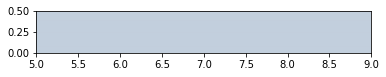

In [90]:
plt.imshow(visualization_original.df.iloc[:,0:1], interpolation='bilinear', origin='lower', extent=(5,9,0,0.5), alpha=0.3, vmin=-3, vmax=30)

fixed acidity fixed acidity
fixed acidity volatile acidity
fixed acidity citric acid
volatile acidity fixed acidity
volatile acidity volatile acidity
volatile acidity citric acid
citric acid fixed acidity
citric acid volatile acidity
citric acid citric acid


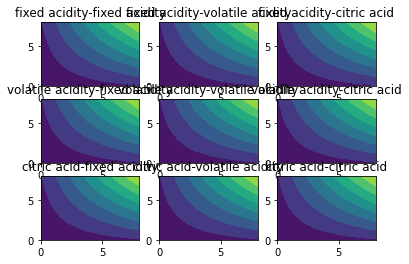

In [71]:
feature_names = visualization_original.feature_names[0:3]

fig, axs = plt.subplots(nrows=len(feature_names), ncols=len(feature_names))

x = np.arange(1, 10)
y = x.reshape(-1, 1)
h = x * y

# I go through all the features with all the features
for index_x, feature_x in enumerate(feature_names):
    for index_y, feature_y in enumerate(feature_names):
        axs[index_x, index_y].contourf(h)
        axs[index_x, index_y].set_title(feature_x + "-" + feature_y)
        print(feature_x, feature_y)

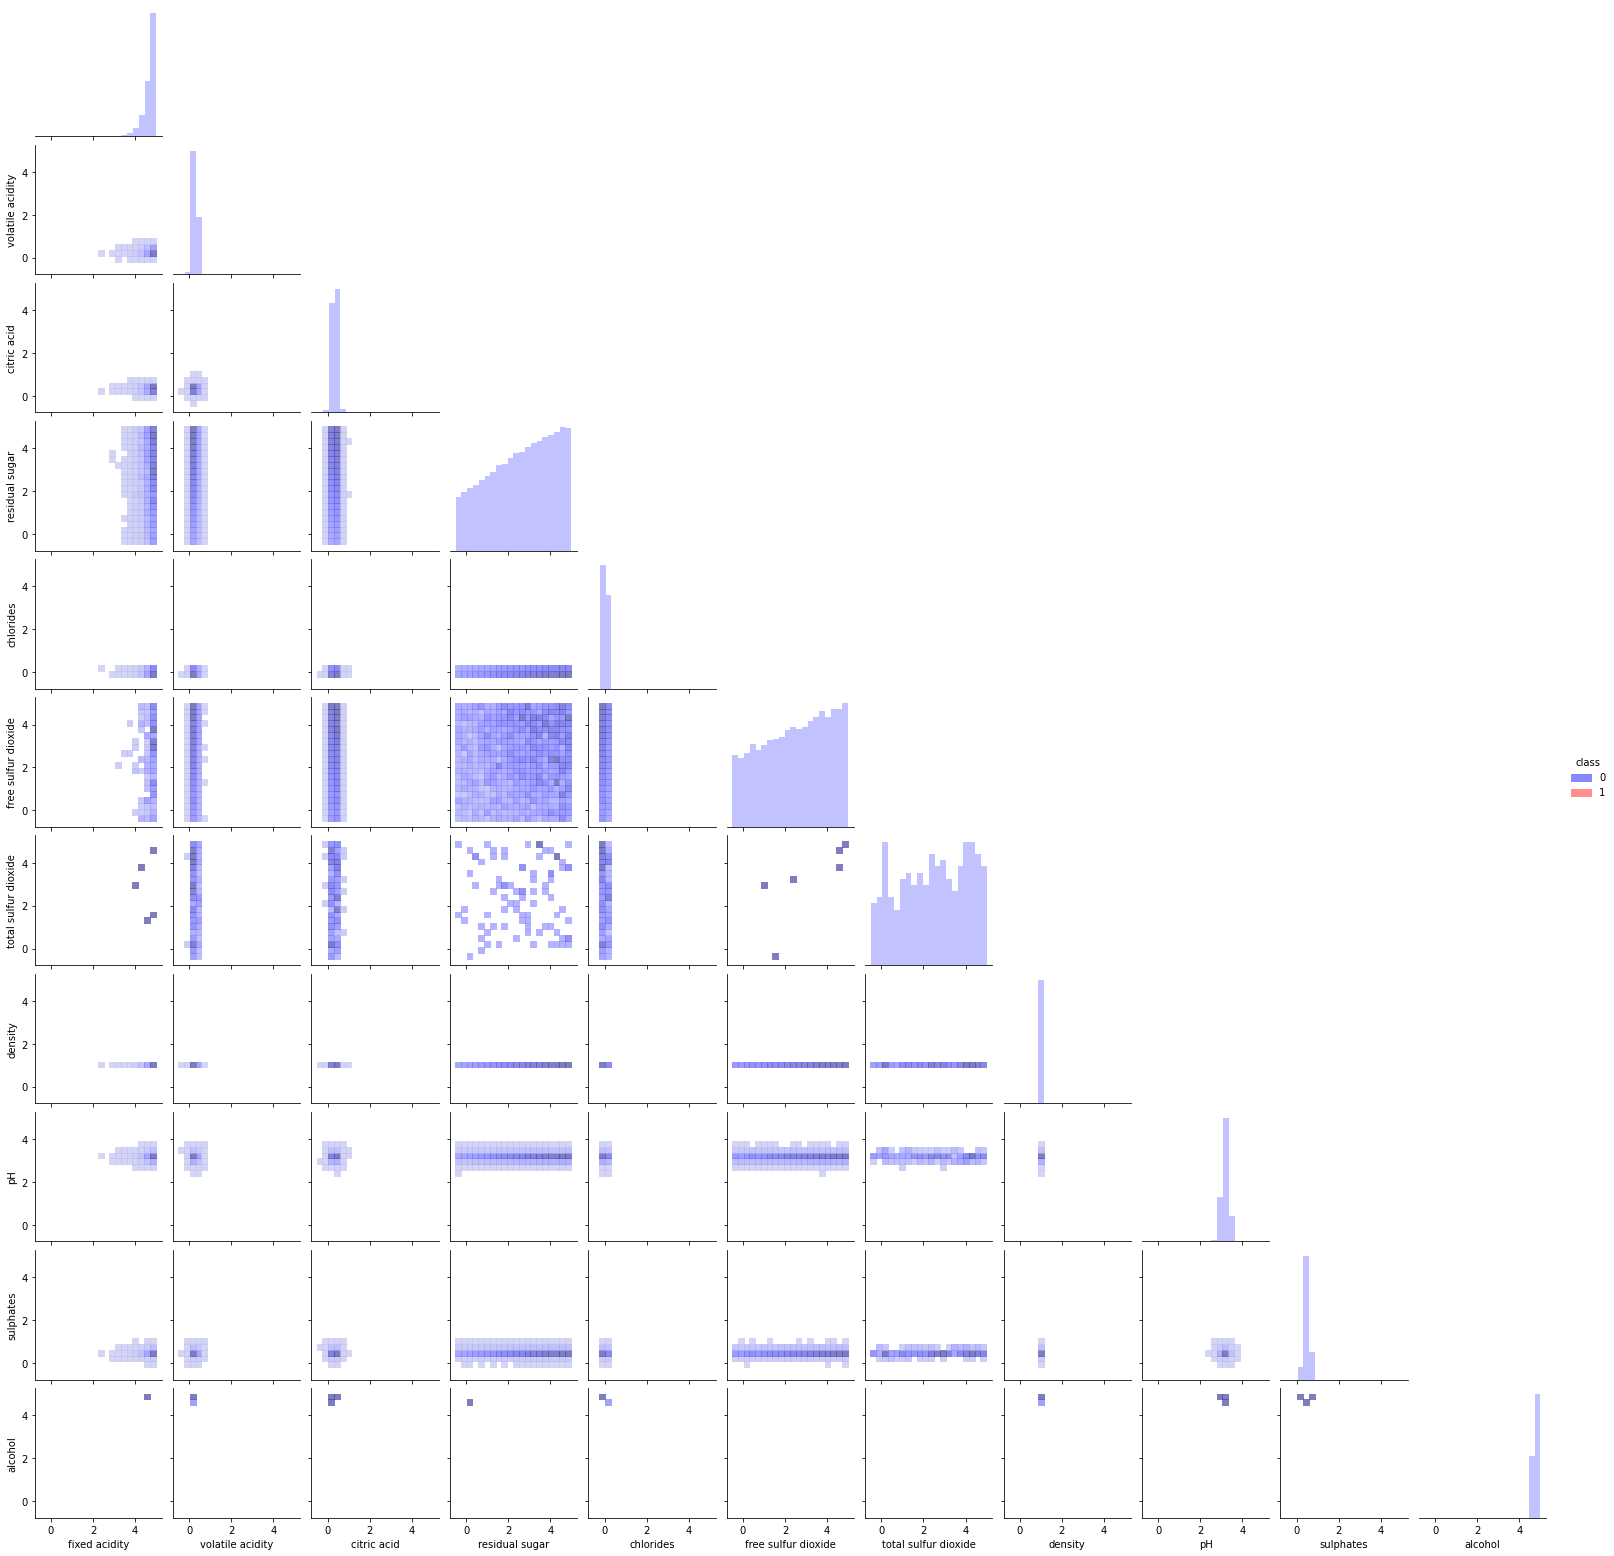

In [92]:
max_nfeatures = len(visualization_original.feature_names)
#x_min = feature_description[var_name]
#x_max = feature_description[]
#y_min = feature_description[]
#y_max = feature_description[]
g = sns.pairplot(visualization_original.df[visualization_original.df["class"]==0], 
                 vars=[var_name for var_name in visualization_original.feature_names[:max_nfeatures]], hue="class", kind="hist", #,markers="s",
                 palette=colors, height=2, corner=True, diag_kws={"linewidth":0, "bins": list(np.linspace(-0.5, 5, num=21))},
                 plot_kws={"linewidths": 0, "edgecolor": "none", "alpha":0.7, "bins": list(np.linspace(-0.5, 5, num=21))}, 
                 ) #.set(xlim=(-2,2), ylim = (-2,2))
plt.show()

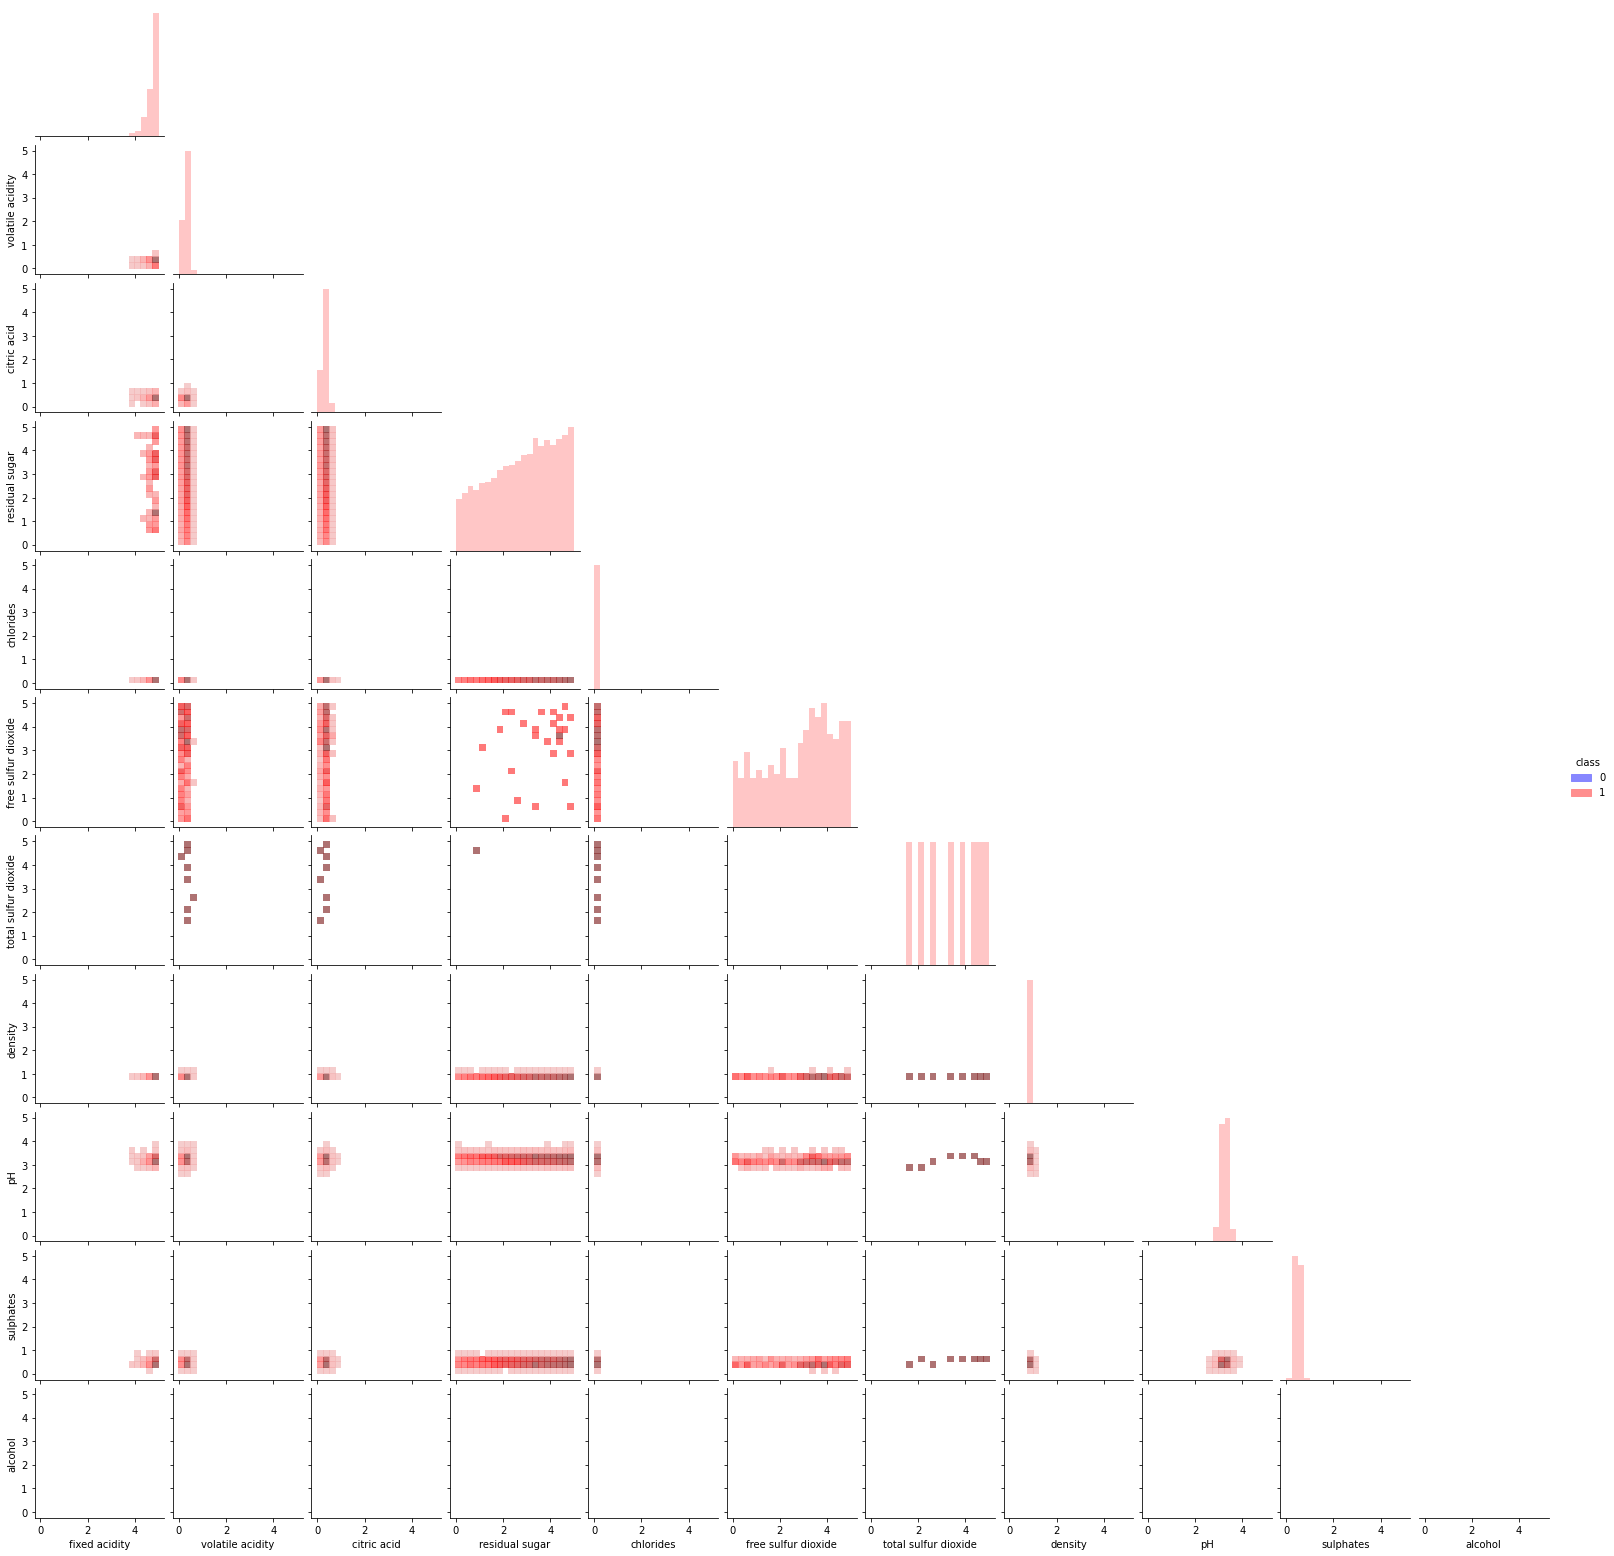

In [91]:
g = sns.pairplot(visualization_original.df[visualization_original.df["class"]==1], 
                 vars=[var_name for var_name in visualization_original.feature_names[:max_nfeatures]], hue="class", kind="hist", #,markers="s",
                 palette=colors, height=2, corner=True, diag_kws={"linewidth":0, "bins": list(np.linspace(0, 5, num=21))},
                 plot_kws={"linewidths": 0, "edgecolor": "none", "alpha":0.7, "bins": list(np.linspace(0, 5, num=21))}, 
                 ) #.set(xlim=(-2,2), ylim = (-2,2))
plt.show()

-----
-----

In [ ]:
feature_description = {
 'fixed acidity': {
  'min': 1,
  'max': 15,
  'mean': 7,
  'sigma': 7},
 'volatile acidity': {
  'min': 0,
  'max': 7,
  'mean': 3,
  'sigma': 6},
 'citric acid': {
  'min': 0,
  'max': 8,
  'mean': 5,
  'sigma': 6},
 'residual sugar': {
  'min': 0,
  'max': 100,
  'mean': 50,
  'sigma': 60},
 'chlorides': {
  'min': 0,
  'max': 5,
  'mean': 2,
  'sigma': 3},
 'free sulfur dioxide': {
  'min': 0,
  'max': 1000,
  'mean': 500,
  'sigma': 800},
 'total sulfur dioxide': {
  'min': 0,
  'max': 1000,
  'mean': 500,
  'sigma': 800},
 'density': {
  'min': 0,
  'max': 2,
  'mean': 1,
  'sigma': 0.8},
 'pH': {
  'min': 0,
  'max': 5,
  'mean': 2,
  'sigma': 3},
 'sulphates': {
  'min': 0,
  'max': 5,
  'mean': 2,
  'sigma': 3},
 'alcohol': {
  'min': 5,
  'max': 20,
  'mean': 10,
  'sigma': 8}}

In [213]:
feature_description = {
 'fixed acidity': {
  'min': 1,
  'max': 15,
  'mean': 0,
  'sigma': 1},
 'volatile acidity': {
  'min': 0,
  'max': 7,
  'mean': 0,
  'sigma': 1},
 'citric acid': {
  'min': 0,
  'max': 8,
  'mean': 0,
  'sigma': 1},
 'residual sugar': {
  'min': 0,
  'max': 100,
  'mean': 0,
  'sigma': 1},
 'chlorides': {
  'min': 0,
  'max': 5,
  'mean': 0,
  'sigma': 1},
 'free sulfur dioxide': {
  'min': 0,
  'max': 1000,
  'mean': 0,
  'sigma': 1},
 'total sulfur dioxide': {
  'min': 0,
  'max': 1000,
  'mean': 0,
  'sigma': 1},
 'density': {
  'min': 0,
  'max': 2,
  'mean': 0,
  'sigma': 1},
 'pH': {
  'min': 0,
  'max': 5,
  'mean': 0,
  'sigma': 1},
 'sulphates': {
  'min': 0,
  'max': 5,
  'mean': 0,
  'sigma': 1},
 'alcohol': {
  'min': 5,
  'max': 20,
  'mean': 0,
  'sigma': 1}}

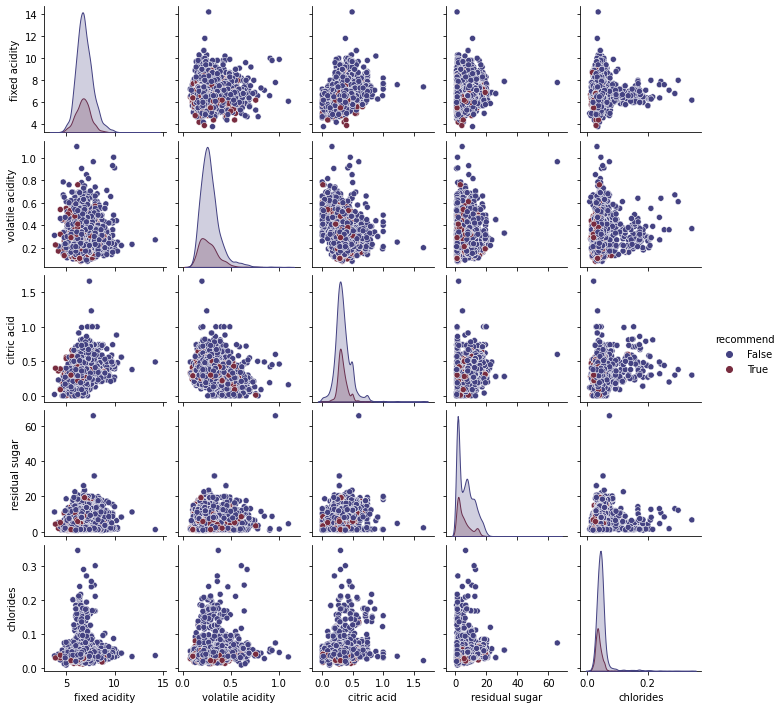

In [97]:
g = sns.pairplot(wine_model.dataset.df, vars=[i for i in wine_model.dataset.df.columns[:5]],
                 hue=wine_model.dataset.df.columns[-1], 
                 palette="icefire", height=2) #.set(xlim=(-25,25), ylim = (-25,25))#, , kind="kde")
plt.show()

## Generate synthetic dataset

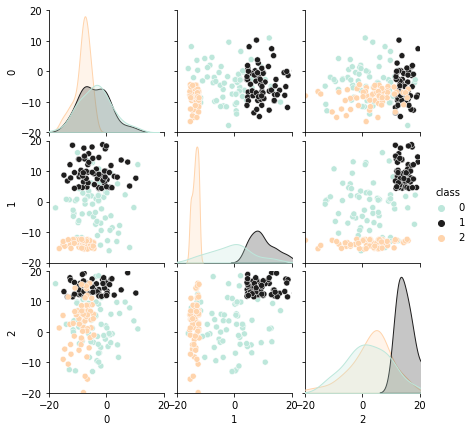

In [20]:
g = sns.pairplot(normal_tree2SVC_training.df, vars=[i for i in range(nfeatures)], hue="class", 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
plt.show()

<a name="Results">

----
## Results summary

Clearly, using the balancing option for the sampler yields better results than not using them:

In [22]:
evaluation_SVC2tree_imbalanced

{'Original Model Accuracy (test)': 0.9775,
 'Copy Model Accuracy (test)': 0.365,
 'Empirical Fidelity Error (synthetic)': 0.12,
 'Empirical Fidelity Error (test)': 0.6575,
 'Replacement Capability (synthetic)': 0.88,
 'Replacement Capability (test)': 0.3734015345268542}

In [23]:
evaluation_SVC2tree_balanced

{'Original Model Accuracy (test)': 0.9775,
 'Copy Model Accuracy (test)': 0.9725,
 'Empirical Fidelity Error (synthetic)': 0.06565656565656564,
 'Empirical Fidelity Error (test)': 0.010000000000000009,
 'Replacement Capability (synthetic)': 0.9343434343434344,
 'Replacement Capability (test)': 0.9948849104859335}

In [24]:
evaluation_tree2SVC_imbalanced

{'Original Model Accuracy (test)': 0.9975,
 'Copy Model Accuracy (test)': 0.365,
 'Empirical Fidelity Error (synthetic)': 0.08999999999999997,
 'Empirical Fidelity Error (test)': 0.6375,
 'Replacement Capability (synthetic)': 0.91,
 'Replacement Capability (test)': 0.3659147869674185}

In [25]:
evaluation_tree2SVC_balanced

{'Original Model Accuracy (test)': 0.9975,
 'Copy Model Accuracy (test)': 0.97,
 'Empirical Fidelity Error (synthetic)': 0.06060606060606055,
 'Empirical Fidelity Error (test)': 0.02749999999999997,
 'Replacement Capability (synthetic)': 0.9393939393939394,
 'Replacement Capability (test)': 0.9724310776942355}

[Index](#Index)  
  
  

----